Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Train/")
data_dir_test = pathlib.Path('./Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% for validation
    subset="training",     # Specify training subset
    seed=123,              # Seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% for validation
    subset="validation",   # Specify validation subset
    seed=123,              # Use the same seed for consistency
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

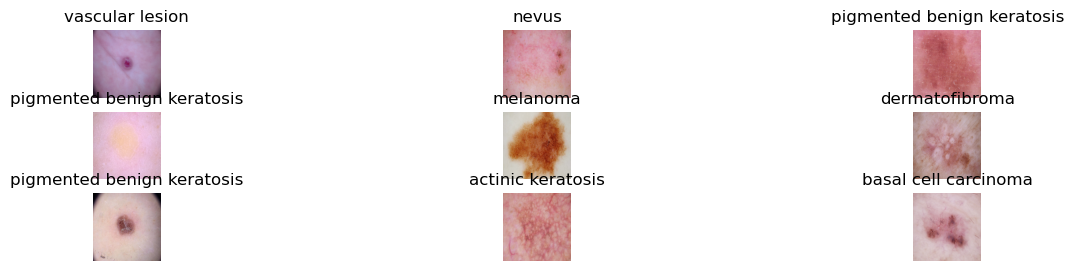

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

# Function to visualize images from the dataset
def visualize_images(dataset, class_names, num_images=5):
    images = []
    labels = []

    for batch_images, batch_labels in dataset.take(1):  # Take one batch of data
        images.extend(batch_images[:num_images])
        labels.extend(batch_labels[:num_images])

    plt.figure(figsize=(15, 3))  # Adjust the figure size as needed
    for i in range(len(images)):
        plt.subplot(3, num_images // 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

# Visualize a few images from different classes in a single horizontal plot
visualize_images(train_ds, class_names, num_images=9)  # Display 9 images (adjust as needed)

# Show the plot

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
# Define your CNN model
model = models.Sequential()

# Normalize pixel values to the [0, 1] range using Rescaling
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Add convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        3

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 44s 708ms/step - loss: 2.3535 - accuracy: 0.2165 - val_loss: 1.9699 - val_accuracy: 0.2483
Epoch 2/20
56/56 [==============================] - 39s 683ms/step - loss: 1.8401 - accuracy: 0.3655 - val_loss: 1.7598 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - 36s 638ms/step - loss: 1.6091 - accuracy: 0.4526 - val_loss: 1.7141 - val_accuracy: 0.3647
Epoch 4/20
56/56 [==============================] - 36s 639ms/step - loss: 1.4541 - accuracy: 0.4872 - val_loss: 1.4034 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 36s 642ms/step - loss: 1.3593 - accuracy: 0.5246 - val_loss: 1.4716 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 38s 679ms/step - loss: 1.3609 - accuracy: 0.5134 - val_loss: 1.4806 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 39s 694ms/step - loss: 1.2683 - accuracy: 0.5564 - val_loss: 1.4663 - val_accuracy: 0.5168

### Visualizing training results

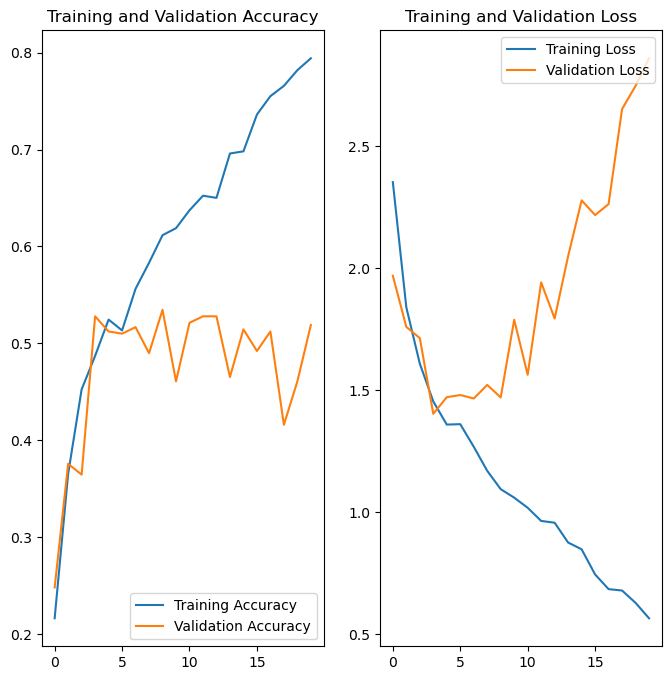

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

# Findings
 - It is clearly visible that the model is overfitting with the training data set
 - main reason is the lack of training data for the model

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define an ImageDataGenerator instance with your desired augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,     # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,            # Shear transformations
    zoom_range=0.2,             # Randomly zoom images by up to 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest',         # Fill in new pixels with the nearest available pixel
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    './Train/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    './Train/', # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


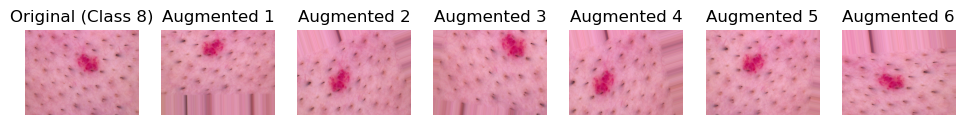

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img


# Load a sample image from your training dataset and assign it a class label
image_path = './Train/vascular lesion/ISIC_0025250.jpg'
class_label = 8

img = load_img(image_path)  # Load the image
x = img_to_array(img)       # Convert to numpy array
x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

# Generate augmented images
num_augmentations = 6  # Number of augmented versions to generate
plt.figure(figsize=(12, 6))

# Display the original image
plt.subplot(1, num_augmentations + 1, 1)
plt.imshow(array_to_img(x[0]))
plt.title('Original (Class {})'.format(class_label))
plt.axis('off')

# Generate and display augmented images
for i, batch in enumerate(datagen.flow(x, batch_size=1)):
    if i >= num_augmentations:
        break

    augmented_img = array_to_img(batch[0])
    plt.subplot(1, num_augmentations + 1, i + 2)
    plt.imshow(augmented_img)
    plt.title('Augmented {}'.format(i + 1))
    plt.axis('off')

plt.show()

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# Define your CNN model


## Your code goes here
model = models.Sequential()

# Normalize pixel values to the [0, 1] range using Rescaling
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Add convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Dropout(0.4))
# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))



### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 20)

C:\Users\euoniss\AppData\Local\Temp\ipykernel_18192\3858405241.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
56/56 [==============================] - 77s 1s/step - loss: 2.0712 - accuracy: 0.1617 - val_loss: 2.0070 - val_accuracy: 0.1683
Epoch 2/20
56/56 [==============================] - 90s 2s/step - loss: 2.0322 - accuracy: 0.1883 - val_loss: 2.0372 - val_accuracy: 0.2067
Epoch 3/20
56/56 [==============================] - 86s 2s/step - loss: 2.0320 - accuracy: 0.2048 - val_loss: 2.0115 - val_accuracy: 0.2163
Epoch 4/20
56/56 [==============================] - 84s 2s/step - loss: 2.0187 - accuracy: 0.1997 - val_loss: 2.0306 - val_accuracy: 0.2091
Epoch 5/20
56/56 [==============================] - 1450s 26s/step - loss: 2.0270 - accuracy: 0.2014 - val_loss: 2.0113 - val_accuracy: 0.2019
Epoch 6/20
56/56 [==============================] - 73s 1s/step - loss: 2.0288 - accuracy: 0.2031 - val_loss: 2.0250 - val_accuracy: 0.1971
Epoch 7/20
56/56 [==============================] - 72s 1s/step - loss: 2.0333 - accuracy: 0.2042 - val_loss: 2.0358 - val_accuracy: 0.2043
Epoch 8/20
56/56 

### Visualizing the results

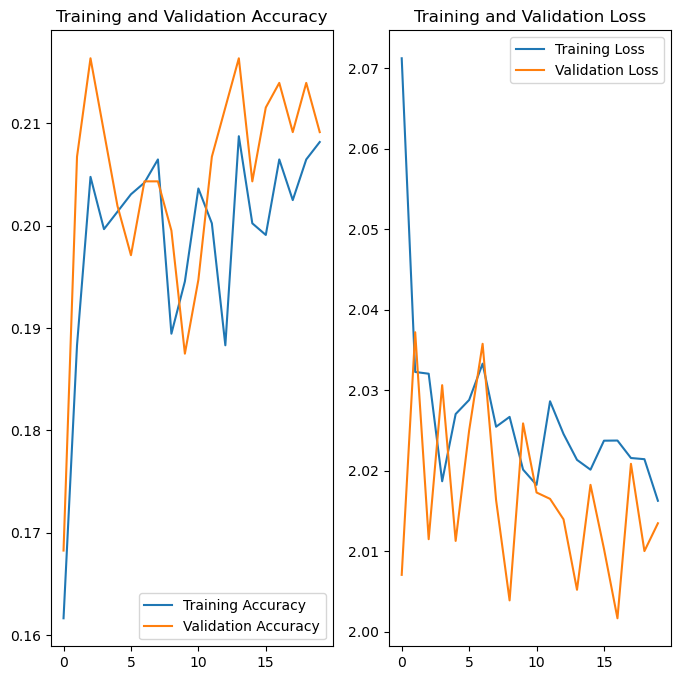

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- Model fit is better after addition of dropuouts, Accuracy is increasing with every iteration, with more epochs Accuracy will Increase.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [58]:
class_names = list(train_generator.class_indices.keys())
class_distribution = [class_names[i] for i in train_generator.classes]

In [57]:
# Get the class distribution


# Calculate the count of each class
unique_classes, class_counts = np.unique(class_distribution, return_counts=True)
# Print or visualize the class distribution
for class_name, count in zip(unique_classes, class_counts):
    print(f"Class '{class_name}': {count} images")

Class 'actinic keratosis': 92 images
Class 'basal cell carcinoma': 301 images
Class 'dermatofibroma': 76 images
Class 'melanoma': 351 images
Class 'nevus': 286 images
Class 'pigmented benign keratosis': 370 images
Class 'seborrheic keratosis': 62 images
Class 'squamous cell carcinoma': 145 images
Class 'vascular lesion': 112 images


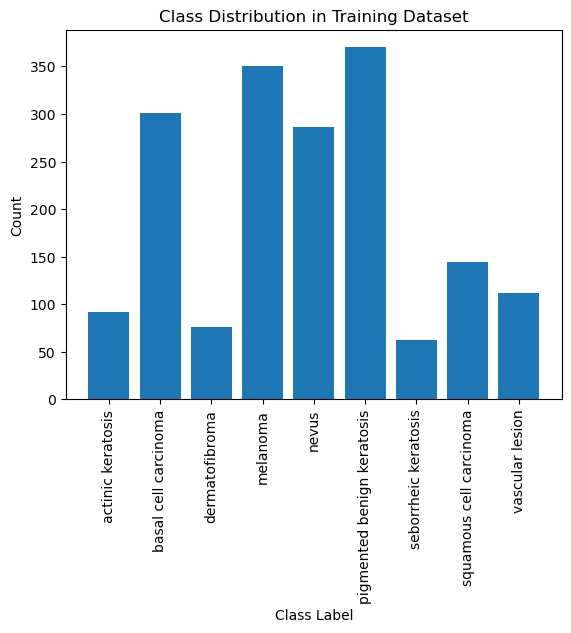

In [60]:
## Your code goes here.

plt.bar(unique_classes, class_counts)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=90)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


1. 'seborrheic keratosis' has least number of samples.
2. 'melenoma' and 'pigmented benign keratosis' is dominating the date in terms proportionate number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [62]:
pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [63]:
path_to_training_dataset="./Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24392FA02B0>: 100%|█| 500/500 [00:03<00:00, 160.37 Samples


Initialised with 376 image(s) found.
Output directory set to ./Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x243868208B0>: 100%|█| 500/500 [00:03<00:00, 149.16 Samples


Initialised with 95 image(s) found.
Output directory set to ./Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x24392CC4370>: 100%|█| 500/500 [00:03<00:


Initialised with 438 image(s) found.
Output directory set to ./Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2438412FB50>: 100%|█| 500/500 [00:22<00:00, 22.67 Samples


Initialised with 357 image(s) found.
Output directory set to ./Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x2438677E1F0>: 100%|█| 500/500 [00:20<00:00, 24.20 Sample


Initialised with 462 image(s) found.
Output directory set to ./Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x24383C406A0>: 100%|█| 500/500 [00:04<00:00, 113.32 Samples


Initialised with 77 image(s) found.
Output directory set to ./Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2438684B880>: 100%|█| 500/500 [00:10<00:00, 45.89 Samples


Initialised with 181 image(s) found.
Output directory set to ./Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x243A8750280>: 100%|█| 500/500 [00:04<00:00, 112.62 Samples


Initialised with 139 image(s) found.
Output directory set to ./Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x243EF72B7F0>: 100%|█| 500/500 [00:04<00:00, 113.29 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [97]:
from glob import glob
old_list = [x for x in glob(os.path.join(data_dir_train,'*', '*.jpg'))]
old_list

['Train\\actinic keratosis\\ISIC_0025780.jpg',
 'Train\\actinic keratosis\\ISIC_0025803.jpg',
 'Train\\actinic keratosis\\ISIC_0025825.jpg',
 'Train\\actinic keratosis\\ISIC_0025953.jpg',
 'Train\\actinic keratosis\\ISIC_0025957.jpg',
 'Train\\actinic keratosis\\ISIC_0025992.jpg',
 'Train\\actinic keratosis\\ISIC_0026040.jpg',
 'Train\\actinic keratosis\\ISIC_0026149.jpg',
 'Train\\actinic keratosis\\ISIC_0026171.jpg',
 'Train\\actinic keratosis\\ISIC_0026194.jpg',
 'Train\\actinic keratosis\\ISIC_0026212.jpg',
 'Train\\actinic keratosis\\ISIC_0026457.jpg',
 'Train\\actinic keratosis\\ISIC_0026468.jpg',
 'Train\\actinic keratosis\\ISIC_0026525.jpg',
 'Train\\actinic keratosis\\ISIC_0026575.jpg',
 'Train\\actinic keratosis\\ISIC_0026625.jpg',
 'Train\\actinic keratosis\\ISIC_0026626.jpg',
 'Train\\actinic keratosis\\ISIC_0026650.jpg',
 'Train\\actinic keratosis\\ISIC_0026702.jpg',
 'Train\\actinic keratosis\\ISIC_0026709.jpg',
 'Train\\actinic keratosis\\ISIC_0026729.jpg',
 'Train\\acti

In [98]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))

### Lets see the distribution of augmented data after adding new images to the original training data.

In [99]:
lesion_list_old = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_old

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [110]:
original_dict = dict(zip(old_list, lesion_list_old))
original_df = pd.DataFrame(list(original_dict.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis


In [111]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b813bbb4-f5d4-4c3c-a286-903ead72d11a.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_0466e005-3b24-4b72-8f20-641a23ce3eb5.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_367dc58b-e094-4095-85b6-e1c6015295f6.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_4e664a58-0c4a-4ddc-ae73-83c4ed4a1291.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_7e3736a8-0259-4e93-a0fb-b305ee4ef935.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_b116c58f-cbce-4188-a54d-b2feea8ee984.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_fb186875-f967-4823-92b4-e0269390a72a.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_47c0096f-82bc-44d2-b810-a3d1c30d0ad3.jpg',
 'Train\\actinic

In [112]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [113]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [114]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

C:\Users\euoniss\AppData\Local\Temp\ipykernel_18192\390629722.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [115]:
new_df['Label'].value_counts()

actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
melanoma                      1000
nevus                          739
pigmented benign keratosis     500
seborrheic keratosis           500
squamous cell carcinoma        500
vascular lesion                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [116]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [120]:
data_dir_train="./Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [121]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [122]:
## your code goes here
model = models.Sequential()

# Normalize pixel values to the [0, 1] range using Rescaling
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Add convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Dropout(0.4))
# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [123]:
## your code goes here
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [125]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 43, 43, 64)       

#### **Todo:**  Train your model

In [126]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/30
169/169 [==============================] - 132s 774ms/step - loss: 1.8960 - accuracy: 0.3451 - val_loss: 2.1287 - val_accuracy: 0.2019
Epoch 2/30
169/169 [==============================] - 146s 860ms/step - loss: 1.2861 - accuracy: 0.5287 - val_loss: 1.8943 - val_accuracy: 0.2895
Epoch 3/30
169/169 [==============================] - 149s 880ms/step - loss: 1.0313 - accuracy: 0.6319 - val_loss: 1.4135 - val_accuracy: 0.5353
Epoch 4/30
169/169 [==============================] - 146s 859ms/step - loss: 0.7875 - accuracy: 0.7161 - val_loss: 1.2008 - val_accuracy: 0.5820
Epoch 5/30
169/169 [==============================] - 148s 873ms/step - loss: 0.5391 - accuracy: 0.8162 - val_loss: 1.2599 - val_accuracy: 0.5813
Epoch 6/30
169/169 [==============================] - 147s 870ms/step - loss: 0.4294 - accuracy: 0.8472 - val_loss: 2.7637 - val_accuracy: 0.4350
Epoch 7/30
169/169 [==============================] - 145s 856ms/step - loss: 0.3012 - accuracy: 0.8967 - val_loss: 2.1466 -

#### **Todo:**  Visualize the model results

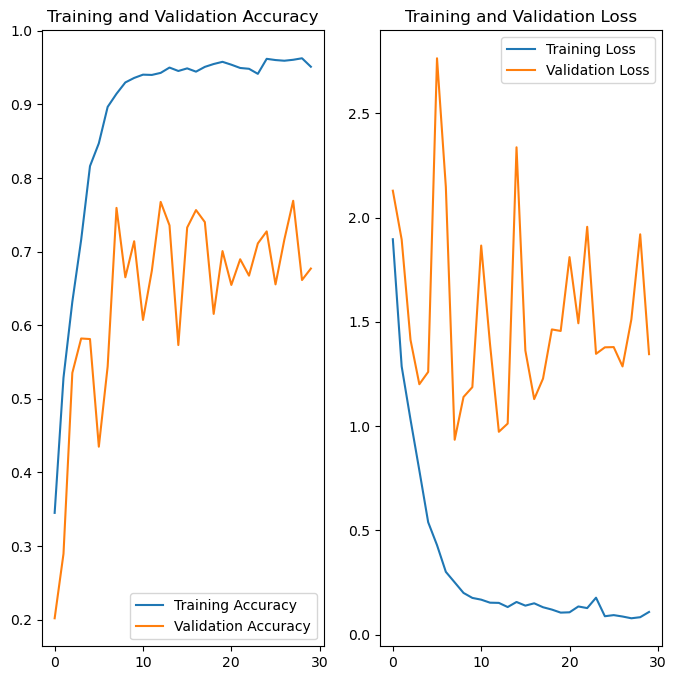

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- the Overall accuracy has been increased 
- there is no sign of overfitting or underfitting.
- rebalancing helps in the overall performance and Accuracy.
- Combination of normalization and Droupout helps to design a better model.